# Data Casal Montserratina

In [1]:
#Data Manipulation
import pandas as pd
import numpy as np

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

#Others
import os
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose

#Parameters Dict
parameters = {
    "paths": {
        "2022_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202201_202206.csv",
        "2022_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202207_202212.csv",
        "2023_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202301_202306.csv",
        "2023_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202307_202312.csv",
        "2024_01_05": "../data/data_casal_montserratina/Casal_Montserratina_202401_202405.csv",
    }
}

# Funciones

In [2]:
def grafico_zoom(df_x, df_y, title="", xaxis_title="", yaxis_title=""):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_x, 
        y=df_y, 
        mode='lines', 
        name='Line', 
        #connectgaps=False 
    ))
    fig.update_layout(
        title=title, 
        xaxis_title=xaxis_title, 
        yaxis_title=yaxis_title, 
        xaxis_tickangle=0, 
        showlegend=False
    )
    fig.show()

In [3]:
#Prints the NaN Values per Column of a dataset
def checkNaNValues(df):
    return print(f"NaN Count per Column", df.isna().any(axis=1).sum())

In [4]:
#Checks if there is any missing time series
def checkMissingData(df, date_column):
    min_date = df[date_column].min()
    max_date = df[date_column].max()

    date_range = pd.date_range(start=min_date, end=max_date, freq='h')
    missing_dates = date_range[~date_range.isin(df[date_column])]
    print(f"Number of Missing Values: {missing_dates.shape[0]}")
    return None if missing_dates.shape[0] == 0 else missing_dates, date_range

In [5]:
def getNumberOfOutliersPerColumn(df, columns_list):
    for col in columns_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        #Calcular los límites inferiores y superiores para identificar outliers
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr

        outliers = ((df[col] < lim_inf) | (df[col] > lim_sup))
        print(f"For {col} Column, the Number of Outliers is {outliers.sum()}. Sus limites son {lim_inf} y {lim_sup}.\n")

In [6]:
def dataframe_slicer (df, fecha_inicial, fecha_final):
    """
    Recorta el DataFrame en base a una fecha inicial y otra final.

    Parameters:
    df (DataFrame): El DataFrame original que contiene los datos.
    fecha_inicial (str): La fecha inicial en formato 'YYYY-MM-DD HH:MM:SS'.
    fecha_final (str): La fecha final en formato 'YYYY-MM-DD HH:MM:SS'.

    Returns:
    DataFrame: Un nuevo DataFrame recortado.
    """
    # Convertir las columnas de fecha a datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Filtrar el DataFrame en base a las fechas
    df_recortado = df[(df['Date'] >= fecha_inicial) & (df['Date'] <= fecha_final)]
    
    return df_recortado

# Load Data

In [7]:
ruta_data = "../data/data_casal_montserratina/"

In [8]:
df1 = pd.read_csv(parameters["paths"]["2022_01_06"], delimiter=";")
df2 = pd.read_csv(parameters["paths"]["2022_07_12"], delimiter=";")
df3 = pd.read_csv(parameters["paths"]["2023_01_06"], delimiter=";")
df4 = pd.read_csv(parameters["paths"]["2023_07_12"], delimiter=";")
df5 = pd.read_csv(parameters["paths"]["2024_01_05"], delimiter=";")

In [9]:
# hago un concat de los 4 datasets, uno a continuación del otro
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

In [10]:
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], format="%d/%m/%Y %H:%M")

df = df.drop(columns=["Tipus lectura", "Període tarifari"]) # Elimino las columnas que no me interesan

df.rename(columns={'TimeStamp': 'Date', 'Valor': 'Consumo'}, inplace=True) 

## Drop duplicates

In [11]:
df.drop_duplicates(keep=False, inplace=True) # duplicados no hay, pero surgió un par de veces ese error al hacer e reindex. 

# Missing values

In [12]:
checkNaNValues(df)
missing_dates, date_range = checkMissingData(df, 'Date')

NaN Count per Column 0
Number of Missing Values: 2908


In [13]:
# TODO porque crajos sale la linea continua? 
grafico_zoom(df["Date"], df["Consumo"],
              "Consumo Eléctrico (con Huecos) Casal La Monserratina - Años 2022, 2023 y 2024", "Consumo [kW]")

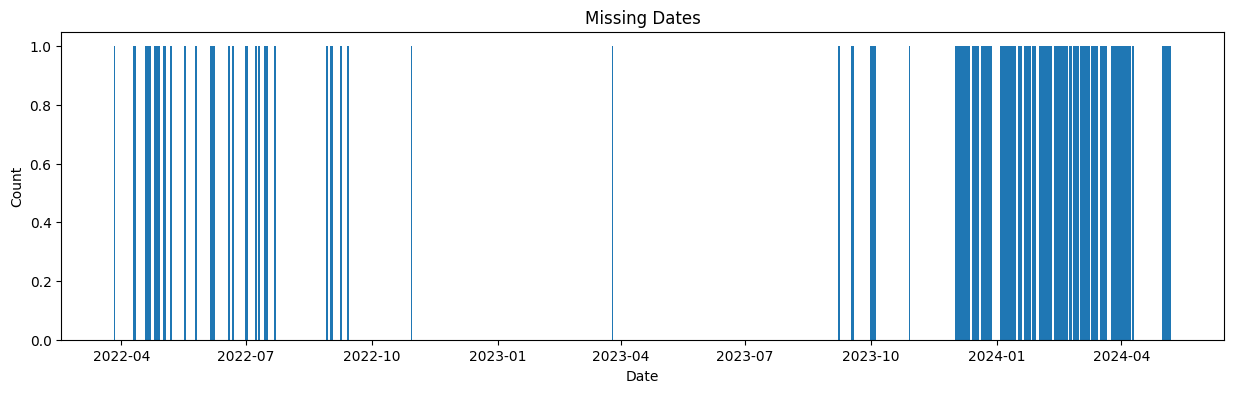

In [14]:
plt.figure(figsize=(15, 4))
plt.bar(missing_dates, [1] * len(missing_dates))
plt.title("Missing Dates")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

In [15]:
def find_first_gap(df, date_column, expected_difference=pd.Timedelta(hours=1)):
    df_sorted = df.sort_values(by=date_column)
    df_sorted['time_diff'] = df_sorted[date_column].diff()
    first_gap = df_sorted[df_sorted['time_diff'] > expected_difference].first_valid_index()
    return df.loc[first_gap] if first_gap else None

In [16]:
df.reset_index(drop=False, inplace=True)
first_gap_row = find_first_gap(df, "Date")
print(f"First Gap Row: {first_gap_row}")

First Gap Row: index                     2042
Date       2022-03-27 03:00:00
Consumo                      2
Name: 2042, dtype: object


In [17]:
 # un ejemplo de las fechas faltantes.

# print(df[(df["Date"]>"2022-04-09 22:00:00") & (df["Date"]<"2022-04-11 01:00:00")])

# # >>>>> notar que entre las 23 del 9/4 a las 00 del 11/4 no hay datos.

print(df[(df["Date"]>="2022-03-27 00:00:00") & (df["Date"]<"2022-03-27 05:00:00")])
# >>>>> notar que entre las 01:00 y las 03:00 del 27/3 no hay datos.
 

      index                Date  Consumo
2040   2040 2022-03-27 00:00:00        2
2041   2041 2022-03-27 01:00:00        3
2042   2042 2022-03-27 03:00:00        2
2043   2043 2022-03-27 04:00:00        2


### rellenar los huecos de Date

In [18]:
df.set_index("Date", inplace=True)

# Reindexa el DataFrame con el nuevo rango de fechas y rellena los valores faltantes con NaN
data_reindexed = df.reindex(date_range)

data_reindexed.reset_index(inplace=True, drop=True)
data_reindexed.rename(columns={'level_0': 'Date'}, inplace=True) 

In [19]:
data_reindexed.head()

index  Consumo
0    0.0      6.0
1    1.0      6.0
2    2.0      5.0
3    3.0      7.0
4    4.0      7.0

Ya no hay huecos en la columna Date, ahora aparecen rellenas!... con Nulls, tiny bam! 

In [20]:
print(data_reindexed[(data_reindexed["Date"]>"2022-04-09 22:00:00") & (data_reindexed["Date"]<"2022-04-11 01:00:00")])

TypeError: Invalid comparison between dtype=float64 and str

In [20]:
getNumberOfOutliersPerColumn(data_reindexed, data_reindexed.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1980. Sus limites son -4.0 y 12.0.



c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Consumo', ylabel='Count'>

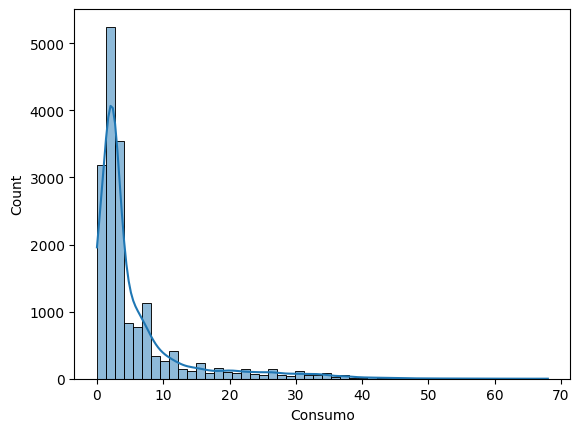

In [21]:
sns.histplot(data_reindexed, x="Consumo", bins=50, kde=True)

La distribución de la función objetivo está muy desplazada a la izquierda. Prácticamente todas las observaciones caen dentro del rango de 0-10 kW, a partir de ese punto la frecuencia de observaciones cae mucho.. hay algunas que llegan hasta casi los 70kW.  En el box plot, se observa la misma información.

<Axes: xlabel='Consumo'>

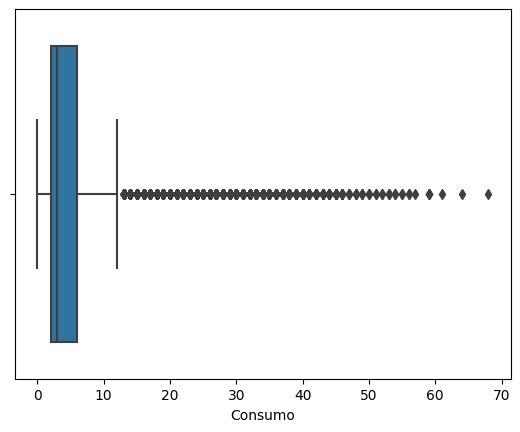

In [22]:
sns.boxplot(data_reindexed, x="Consumo" )

### Interpolación NaN´s  

antes de hacer la interpolación, quiero entender como están distribuidos esos NaN´s a lo largo del DF.

In [23]:
def consecutive_nans(series):
    # Crear una serie booleana que es True donde la serie original es NaN
    is_nan = series.isna()

    # Identificar grupos de NaNs consecutivos
    nan_groups = ((is_nan.shift() != is_nan).cumsum()).where(is_nan, np.nan)
    """
    Esta línea hace varias cosas. 
    1º,  is_nan.shift() != is_nan devuelve una serie booleana que es True en los límites entre los valores NaN y no NaN. 
    2º, cumsum() se usa para asignar un grupo único a cada secuencia de valores NaN consecutivos. 
    3º, where(is_nan, np.nan) reemplaza los valores correspondientes a los no NaN en la serie original con NaN.
    
    """
    # Contar el tamaño/frecuencia de cada grupo
    group_sizes = nan_groups.value_counts()#.sort_index()

    # Imprimir la lista de tamaños de grupos
    return group_sizes.tolist()


2908


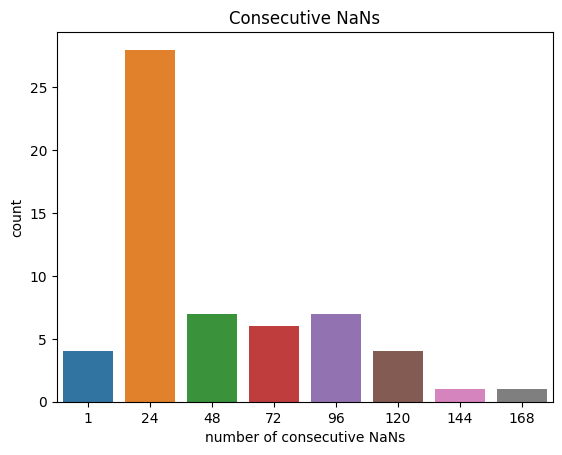

In [24]:
list_consecutive_nans = consecutive_nans(data_reindexed['Consumo'])
print(sum(list_consecutive_nans))

count = pd.Series(list_consecutive_nans).value_counts()
    
ax = sns.barplot(x=count.index, y=count.values)
ax.set_title('Consecutive NaNs')
ax.set_xlabel('number of consecutive NaNs')
ax.set_ylabel('count')

plt.show()

Veo que en general, huecos (como filas de NaN´s consecutivos) se agurpan en bloques de 24. Dado los datos vienen en frecuencia horaria, 24 NaN´s seguidos corresponden a 1 día, y 168 a 7 días. 

Tenía intención de hacer una función que haga interpolación **SOLO** de los bloques de NaN´s cortos, como para no afectar demasiado la función objetivo.
Puede hacerse interpolación de los pocos huecos de 1 hora, y el siguiente treshold sería ya de interpolar 24 horas... interpolaré hasta los bloques de 24 horas.

In [25]:
def interpolate_with_threshold(df, column, threshold):
    # Create a mask of NaNs
    mask = df[column].isna()

    # Identify groups of consecutive NaNs
    mask_diff = mask.diff().fillna(False)
    groups = mask_diff.cumsum()[mask]

    # Count the size of each group
    group_counts = groups.map(groups.value_counts())

    # Create a mask for groups that are less than or equal to the threshold
    interpolate_mask = group_counts <= threshold

    # Interpolate only where the mask is True
    df[column] = df[column].mask(mask).interpolate().where(interpolate_mask, df[column])

    # Count and print the number of interpolated and not interpolated values
    interpolated_count = interpolate_mask.sum()
    not_interpolated_count = mask.sum() - interpolated_count

    print(f"Interpolated count: {interpolated_count}")
    print(f"Not interpolated count: {not_interpolated_count}")

In [26]:
interpolate_with_threshold(data_reindexed, 'Consumo',24)

Interpolated count: 676
Not interpolated count: 2232


C:\Users\afernandez\AppData\Local\Temp\ipykernel_17536\2588710448.py:6: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [27]:
grafico_zoom(data_reindexed["Date"], data_reindexed["Consumo"],
              "Consumo Eléctrico (con (algunos) huecos reindexados) Casal La Monserratina - Años 2022, 2023 y 2024", "Consumo [kW]")

## Gaficas varias de la variable Consumo

### consumo resampleado a una semana

In [28]:
# Weekly Demand Plot
whole_df_1w = df.resample('1W').mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=whole_df_1w.index, y=whole_df_1w["Consumo"], mode='lines'))
fig.update_layout(
    title = "Consumo Eléctrico (Resample 1 semana) - Casal La Monserratina",
    xaxis_title = "Date",
    yaxis_title = "Demand (kWh)",
    width = 850,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### consumo mes a mes

In [29]:
import calendar
from plotly.subplots import make_subplots
def plot_monthly_Consumo(df):
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    
    groups = df.groupby([df.index.year, df.index.month])
    num_plots = len(groups)
    fig = make_subplots(rows=6, cols=2, subplot_titles=[calendar.month_name[i] for i in range(1, 13)], horizontal_spacing=0.1, vertical_spacing=0.05)
    #colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    colors = ['blue', 'orange', 'green']

    for month in range(1, 13):
        row = (month - 1) // 2 + 1
        col = (month - 1) % 2 + 1
        monthly_data = df[df.index.month == month]
        unique_years = monthly_data.index.year.unique()
        for i, year in enumerate(unique_years):
            year_data = monthly_data[monthly_data.index.year == year]
            year_data = year_data.copy()
            year_data.index = year_data.index.map(lambda x: x.replace(year=2022))  # Normalizar el año para superponer curvas
            fig.add_trace(
                go.Scatter(x=year_data.index, y=year_data["Consumo"], mode='lines', name=f"{year}",
                           legendgroup=f"{month}", line=dict(color=colors[i % len(colors)]), showlegend=False),
                row=row, col=col
            )
        if month == 1:
            for i, year in enumerate(unique_years):
                fig.add_trace(
                    go.Scatter(x=[None], y=[None], mode='lines', name=f"{year}",
                            legendgroup=f"{month}", line=dict(color=colors[i % len(colors)]), showlegend=True),
                    row=row, col=col
                )
                
        fig.update_xaxes(title_text="Date", row=row, col=col)
        fig.update_yaxes(title_text="Consumo (kWh)", row=row, col=col)
    fig.update_layout(
        title = {
            "text": "Monthly Energy Consumo",
            'x': 0.5,
            'xanchor': 'center'
        },
        xaxis_title="Date",
        yaxis_title="Consumo (kWh)",
        width=1200,
        height=2000,
        margin=dict(l=20, r=20, t=45, b=20)   
    )
    fig.show()

plot_monthly_Consumo(df)

## Slice Dataset
la idea es quedarse solo con la zona central, dejando fuera los picos del inicio, y los huecos del final. 

In [30]:
# Definir las fechas inicial y final
fecha_inicial = '2022-07-02 00:00:00' # 'YYYY-MM-DD HH:MM:SS'.
fecha_final = '2023-11-30 23:00:00'

# Obtener el DataFrame recortado
df_sliced = dataframe_slicer(data_reindexed, fecha_inicial, fecha_final)

In [31]:

grafico_zoom(df_sliced["Date"], df_sliced["Consumo"],
              "Consumo Eléctrico (CON HUECOS) Casal La Monserratina - de Julio 2022 a Dic 2023 ", "Consumo [kW]")

### Outliers del df_sliced

In [32]:
getNumberOfOutliersPerColumn(df_sliced, df_sliced.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1306. Sus limites son -2.5 y 9.5.



c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



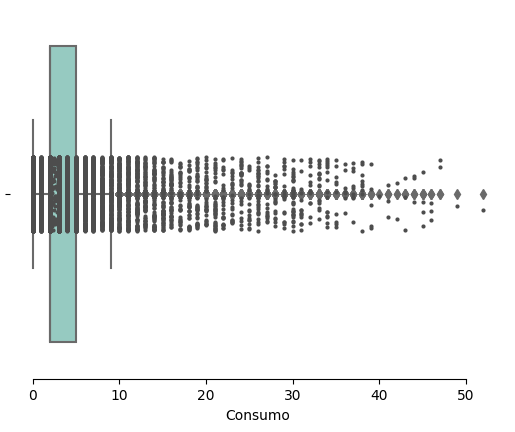

In [33]:
sns.boxplot(df_sliced, x="Consumo", width=0.8, palette="Set3")
# Add in points to show each observation
sns.stripplot(df_sliced, x="Consumo", size=3, color=".3")
sns.despine(trim=True, left=True)

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Consumo', ylabel='Count'>

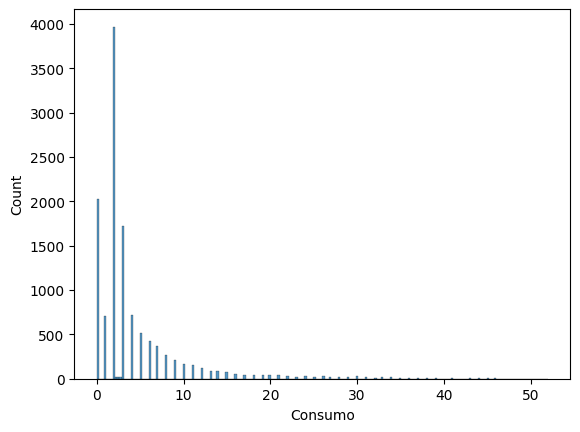

In [34]:
sns.histplot(df_sliced, x="Consumo")

## Smoothing w/moving average

In [35]:
from statsmodels.robust.scale import mad

# Define the window size for the rolling mean
window_size = 3 # datos horarios, es decir, que el window_size esta en horas.


# Calculate the rolling mean
df_sliced['Consumo_smooth_mean'] = df_sliced['Consumo'].rolling(window=window_size).mean()
#df_sliced['Consumo_smooth_std'] = df_sliced['Consumo'].rolling(window=window_size).std()
#df_sliced['Consumo_smooth_MAD'] = df_sliced['Consumo'].rolling(window=window_size).apply(mad)

C:\Users\afernandez\AppData\Local\Temp\ipykernel_17536\2023304538.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
# Create traces for original and smoothed data
trace_original = go.Scatter(x=df_sliced["Date"], y=df_sliced['Consumo'], mode='lines', name='Original')
trace_smoothed_mean = go.Scatter(x=df_sliced["Date"], y=df_sliced['Consumo_smooth_mean'], mode='lines', name='Smoothed Mean')

# Create layout
layout = go.Layout(title='Original vs Smoothed Data', xaxis=dict(title='Date'), yaxis=dict(title='Consumption [kW]'))

# Create figure
fig = go.Figure(data=[trace_original, trace_smoothed_mean], layout=layout)

# Show figure
fig.show()

el rooling average lo que hace es calcular una media variable de la ventana definida. en este caso son bloques horarios, ej: window_size=3 hace un promedio de las ultimas 3 horas (aun no se ha aplicado upsampling a 15 min). Si bien no es la mejor idea utilizar una variable modificada como funcion objetivo, pareciera que la curva resultante tiene mucho menos ruido y copia casi perfectamente la curva original.

### Outliers del smoothed DF

In [37]:
df_sliced.describe()

Date       Consumo  Consumo_smooth_mean
count                12408  12288.000000         12282.000000
mean   2023-03-17 11:30:00      4.222168             4.223036
min    2022-07-02 00:00:00      0.000000             0.000000
25%    2022-11-08 05:45:00      2.000000             2.000000
50%    2023-03-17 11:30:00      2.000000             2.333333
75%    2023-07-24 17:15:00      5.000000             4.666667
max    2023-11-30 23:00:00     52.000000            47.666667
std                    NaN      5.769920             5.224750

In [38]:
getNumberOfOutliersPerColumn(df_sliced, df_sliced.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1306. Sus limites son -2.5 y 9.5.

For Consumo_smooth_mean Column, the Number of Outliers is 1370. Sus limites son -2.0 y 8.666666666666668.



<Axes: xlabel='Consumo_smooth_mean'>

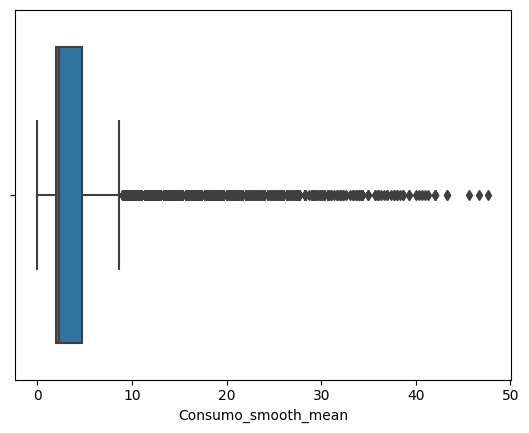

In [39]:
sns.boxplot(df_sliced, x="Consumo_smooth_mean")

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Consumo_smooth_mean', ylabel='Count'>

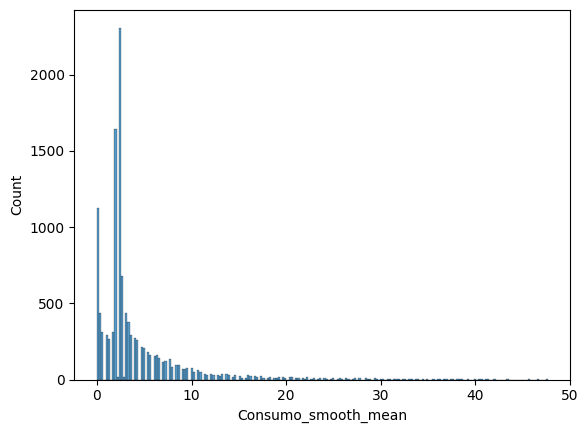

In [40]:
sns.histplot(df_sliced, x="Consumo_smooth_mean")

# upsampling a 15 min

In [41]:
df_upsampled = df_sliced.copy()

In [42]:
df_upsampled.set_index("Date", inplace=True)

In [43]:
df_upsampled = df_upsampled.resample('15min').interpolate(method='time')
df_upsampled

Consumo  Consumo_smooth_mean
Date                                             
2022-07-02 00:00:00     3.00                  NaN
2022-07-02 00:15:00     2.75                  NaN
2022-07-02 00:30:00     2.50                  NaN
2022-07-02 00:45:00     2.25                  NaN
2022-07-02 01:00:00     2.00                  NaN
...                      ...                  ...
2023-11-30 22:00:00     2.00             3.666667
2023-11-30 22:15:00     2.00             3.416667
2023-11-30 22:30:00     2.00             3.166667
2023-11-30 22:45:00     2.00             2.916667
2023-11-30 23:00:00     2.00             2.666667

[49629 rows x 2 columns]

# Merge Consumo con PPV

In [44]:
# Load the DataFrame with the PV & weather data

nombre_archivo = "LaMonserratina_weather_&_PV.csv"

df_PV = pd.read_csv(os.path.join(ruta_data, nombre_archivo))

df_PV.rename(columns={"timestamp_local": "Date"}, inplace=True)
df_PV.drop(columns=["Unnamed: 0"], inplace=True)
#df_PV.set_index("Date", inplace=True)


In [45]:
# Rename para quitar espacios y [] de los nombres de las columnas
df_PV.rename(columns={
       'pres [mb]':'pres_mb', 
       'slp [mb]':"slp_mb", 
       'wind_dir [m/s]':'wind_dir_m/s',
       'wind_gust_spd [m/s]':'wind_gust_spd_m/s', 
       'wind_spd [m/s]':'wind_spd_m/s', 
       'temp [C]':'temp_C', 
       'app_temp [C]':'app_temp_C', 
       'rh [%]':'rh_%', 
       'dewpt [C]':'dewpt_C', 
       'clouds [%]':'clouds_%', 
       'precip [mm]':'precip_mm', 
       'dhi [W/m^2]':'dhi_W/m2', 
       'dni [W/m^2]':'dni_W/m2', 
       'ghi [W/m^2]':'ghi_W/m2', 
       'solar_rad [W/m^2]':'solar_rad_W/m2',
       'uv [0-11+]':'uv_0-11', 
       'elev_angle [º]':'elev_angle_º', 
       'azimuth [º]':'azimuth_º',
       'Temp interna Modulo [C]':'Temp interna Modulo_C', 
       "PV [Wh]" : "PV_Wh"
       }, inplace=True)

In [46]:
df_PV.head(3)

Date  pres_mb  slp_mb  wind_dir_m/s  wind_gust_spd_m/s  \
0  2022-01-01 00:00:00   1027.0  1028.0         360.0                4.0   
1  2022-01-01 00:15:00   1027.0  1028.0         357.5                4.1   
2  2022-01-01 00:30:00   1027.0  1028.0         355.0                4.2   

   wind_spd_m/s  temp_C  app_temp_C   rh_%  dewpt_C  dhi_W/m2  dni_W/m2  \
0         1.275    10.7        10.7  88.25    9.500       0.0       0.0   
1         1.400    10.7        10.7  88.25    9.325       0.0       0.0   
2         1.800    10.7        10.7  88.25    9.150       0.0       0.0   

   ghi_W/m2  solar_rad_W/m2  uv_0-11  elev_angle_º  azimuth_º  \
0       0.0             0.0      0.0         -58.4    323.400   
1       0.0             0.0      0.0         -58.4    243.575   
2       0.0             0.0      0.0         -58.4    163.650   

   Temp interna Modulo_C  PV_Wh  
0              22.066196    0.0  
1              22.066196    0.0  
2              22.066196    0.0

In [47]:
checkNaNValues(df_PV)
missing_dates, date_range = checkMissingData(df_PV, 'Date')

NaN Count per Column 0
Number of Missing Values: 0


C:\Users\afernandez\AppData\Local\Temp\ipykernel_17536\1343014103.py:7: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



In [48]:
#df3.set_index("Date", inplace=True)

df_upsampled.rename(columns={"Consumo": "Consumo_kW"}, inplace=True)
df_upsampled.rename(columns={"Consumo_smooth_mean": "Consumo_smooth_mean_kW"}, inplace=True)

# df_upsampled.reset_index(inplace=True)
# df_upsampled.drop(columns=["index"], inplace=True)


df_upsampled.head(20)

Consumo_kW  Consumo_smooth_mean_kW
Date                                                   
2022-07-02 00:00:00        3.00                     NaN
2022-07-02 00:15:00        2.75                     NaN
2022-07-02 00:30:00        2.50                     NaN
2022-07-02 00:45:00        2.25                     NaN
2022-07-02 01:00:00        2.00                     NaN
2022-07-02 01:15:00        2.25                     NaN
2022-07-02 01:30:00        2.50                     NaN
2022-07-02 01:45:00        2.75                     NaN
2022-07-02 02:00:00        3.00                2.666667
2022-07-02 02:15:00        2.75                2.583333
2022-07-02 02:30:00        2.50                2.500000
2022-07-02 02:45:00        2.25                2.416667
2022-07-02 03:00:00        2.00                2.333333
2022-07-02 03:15:00        2.25                2.416667
2022-07-02 03:30:00        2.50                2.500000
2022-07-02 03:45:00        2.75                2.583333
2022-07-02 04:00:00        3.00                2.666667
2022-07-02 04:15:00        3.00                2.666667
2022-07-02 04:30:00        3.00                2.666667
2022-07-02 04:45:00        3.00                2.666667

In [49]:
df_upsampled.reset_index(inplace=True)
df_upsampled['Date'] = pd.to_datetime(df_upsampled['Date'])
df_PV['Date'] = pd.to_datetime(df_PV['Date'])

In [50]:
df4 = df_upsampled.merge(df_PV, how="inner", on="Date")
df4.sample(2)

Date  Consumo_kW  Consumo_smooth_mean_kW  pres_mb  \
29968 2023-05-10 04:00:00         2.0                2.000000   1017.0   
39537 2023-08-17 20:15:00         2.0                1.166667   1011.0   

       slp_mb  wind_dir_m/s  wind_gust_spd_m/s  wind_spd_m/s  temp_C  \
29968  1018.0         240.0              2.600        1.2750   17.00   
39537  1012.0          85.0              6.625        6.3125   27.75   

       app_temp_C  ...  dewpt_C  dhi_W/m2  dni_W/m2  ghi_W/m2  solar_rad_W/m2  \
29968      17.000  ...     14.3      0.00       0.0      0.00            0.00   
39537      30.725  ...     22.2     33.75     297.0     66.75           62.25   

       uv_0-11  elev_angle_º  azimuth_º  Temp interna Modulo_C         PV_Wh  
29968     0.00       -23.600      34.50              24.911956  0.000000e+00  
39537     1.05         5.075     283.05              36.511499  1.670813e+06  

[2 rows x 21 columns]

hay un probma con las unidades, Consumo de Red esta en kW, y PV en W.. ajusto PV/1000. y agrego las unidades a los nombres para evitar confusiones

In [51]:
df4["PV_Wh"] = (df4["PV_Wh"]/1000000).round(3)
df4.sample(5)

Date  Consumo_kW  Consumo_smooth_mean_kW  pres_mb  \
30237 2023-05-12 23:15:00        2.00                2.750000   1015.0   
21028 2023-02-06 01:00:00        2.00                2.000000   1027.0   
10499 2022-10-19 08:45:00       14.75                9.666667   1020.0   
32204 2023-06-02 11:00:00        0.00                0.666667   1013.0   
41197 2023-09-04 03:15:00        2.00                2.000000   1016.0   

       slp_mb  wind_dir_m/s  wind_gust_spd_m/s  wind_spd_m/s  temp_C  \
30237  1016.0         272.5              2.700         2.475  13.375   
21028  1028.0         360.0              3.600         3.100   7.200   
10499  1021.0         357.5              3.025         2.975  20.100   
32204  1014.0         150.0              4.090         4.090  21.600   
41197  1017.0          70.0             12.200         8.190  27.250   

       app_temp_C  ...  dewpt_C  dhi_W/m2  dni_W/m2  ghi_W/m2  solar_rad_W/m2  \
30237      13.375  ...    7.700       0.0       0.0      0.00            0.00   
21028       5.100  ...    2.300       0.0       0.0      0.00            0.00   
10499      20.400  ...   17.950      36.0     324.0     77.25           65.25   
32204      21.700  ...   16.100     112.0     870.0    769.00          735.00   
41197      26.950  ...   11.975       0.0       0.0      0.00            0.00   

       uv_0-11  elev_angle_º  azimuth_º  Temp interna Modulo_C  PV_Wh  
30237    0.000       -20.425    321.300              23.274514  0.000  
21028    0.000       -58.400    323.400              20.598145  0.000  
10499    0.525         5.725    109.075              33.668995  1.866  
32204    3.800        49.800    104.900              46.744033  4.477  
41197    0.000       -37.650     30.310              29.541963  0.000  

[5 rows x 21 columns]

## add some extra exogenous variables columns

In [52]:
df5 = df4.copy()
df5.sample(1)

Date  Consumo_kW  Consumo_smooth_mean_kW  pres_mb  \
20888 2023-02-04 14:00:00         0.0                0.666667   1024.0   

       slp_mb  wind_dir_m/s  wind_gust_spd_m/s  wind_spd_m/s  temp_C  \
20888  1024.0         350.0                4.8           3.6    19.1   

       app_temp_C  ...  dewpt_C  dhi_W/m2  dni_W/m2  ghi_W/m2  solar_rad_W/m2  \
20888        17.8  ...    -0.25      98.0     813.0     511.0           511.0   

       uv_0-11  elev_angle_º  azimuth_º  Temp interna Modulo_C  PV_Wh  
20888      2.9          31.0      195.3              44.320521  4.276  

[1 rows x 21 columns]

In [53]:
df5["Year"] = df5["Date"].dt.year
df5["Month"] = df5["Date"].dt.month
df5["Hour"] = df5["Date"].dt.hour
df5["DayOfWeek"] = df5["Date"].dt.day_of_week
df5["DayOfYear"] = df5["Date"].dt.day_of_year
df5["Day"] = df5["Date"].dt.day
#df5["Minute"] = df5["Date"].dt.minute

In [54]:
#Sine and Cosine Transformations
def cyclical_encoding(df, cycle_length_list, columns):
    for col, cycle_length in zip(columns, cycle_length_list):
        if df[col].min == 0:
            df[f"{col}_sin"] = np.sin((df[col] / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos((df[col] / cycle_length) * np.pi * 2).round(4)
        else:
            df[f"{col}_sin"] = np.sin(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
    return df

In [55]:

#Add isWeekend Column based in DayOfTheWeek Value
df5["isWeekend"] = df5["DayOfWeek"].isin([5, 6])

cycle_lengths = [24, 7, 12, 365]
cols = ["Hour", "DayOfWeek", "Month", "DayOfYear"]

df5 = cyclical_encoding(df5, cycle_lengths, cols)

df5.sample(5)

Date  Consumo_kW  Consumo_smooth_mean_kW  pres_mb  \
24708 2023-03-16 09:00:00         3.0                3.666667  1017.00   
25713 2023-03-26 20:15:00         2.0                1.500000  1012.25   
23539 2023-03-04 04:45:00         2.0                2.000000  1019.00   
21296 2023-02-08 20:00:00        15.0               20.000000  1029.00   
30284 2023-05-13 11:00:00         0.0                0.000000  1016.00   

        slp_mb  wind_dir_m/s  wind_gust_spd_m/s  wind_spd_m/s  temp_C  \
24708  1017.00         360.0              4.090        4.0900  11.000   
25713  1013.25         290.0             12.200        8.1900  21.375   
23539  1019.25         357.5              5.625        4.8675   6.850   
21296  1030.00          80.0             10.800        8.1900   8.600   
30284  1016.00          20.0              3.100        3.1000  17.600   

       app_temp_C  ...  Day  isWeekend  Hour_sin  Hour_cos  DayOfWeek_sin  \
24708      11.000  ...   16      False    0.8660   -0.5000         0.9749   
25713      19.975  ...   26       True   -0.9659    0.2588        -0.9749   
23539       4.200  ...    4       True    0.7071    0.7071        -0.4339   
21296       8.600  ...    8      False   -0.9659    0.2588         0.7818   
30284      17.600  ...   13       True    0.5000   -0.8660        -0.4339   

       DayOfWeek_cos  Month_sin  Month_cos  DayOfYear_sin  DayOfYear_cos  
24708        -0.2225      0.866      0.500         0.9562         0.2926  
25713        -0.2225      0.866      0.500         0.9922         0.1245  
23539        -0.9010      0.866      0.500         0.8759         0.4825  
21296         0.6235      0.500      0.866         0.6085         0.7936  
30284        -0.9010      0.866     -0.500         0.7639        -0.6453  

[5 rows x 36 columns]

In [56]:
def generateHolidayVar(df):
    df["Reduced_Date"] = df["Date"].dt.date
    list_holidays = holidays.Spain(prov="CT", years=list(df["Year"].unique()))
    list_holidays_dates = np.array(list(list_holidays.keys()), dtype='datetime64')
    df["isHoliday"] = df["Reduced_Date"].isin(list_holidays_dates)
    df = df.drop('Reduced_Date', axis=1)
    return df

df5 = generateHolidayVar(df5)
display(df5[["Date", "isHoliday"]].sample(5))

Date  isHoliday
12884 2022-11-13 05:00:00      False
33423 2023-06-15 03:45:00      False
41462 2023-09-06 21:30:00      False
38825 2023-08-10 10:15:00      False
45776 2023-10-21 20:00:00      False

# Plots

## Demand Distribution Plots

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Consumo_kW', ylabel='Count'>

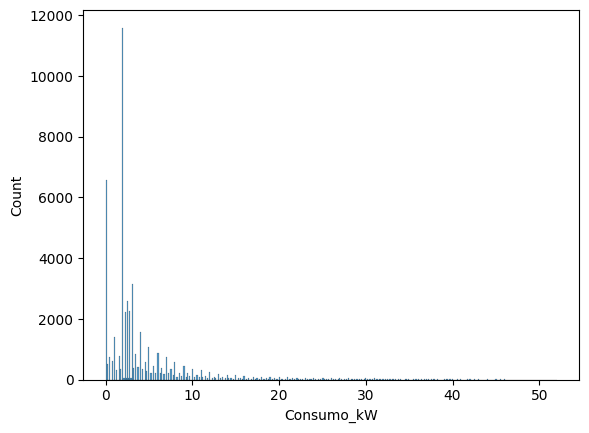

In [57]:
sns.histplot(df5["Consumo_kW"])

Text(0.5, 0.98, '')

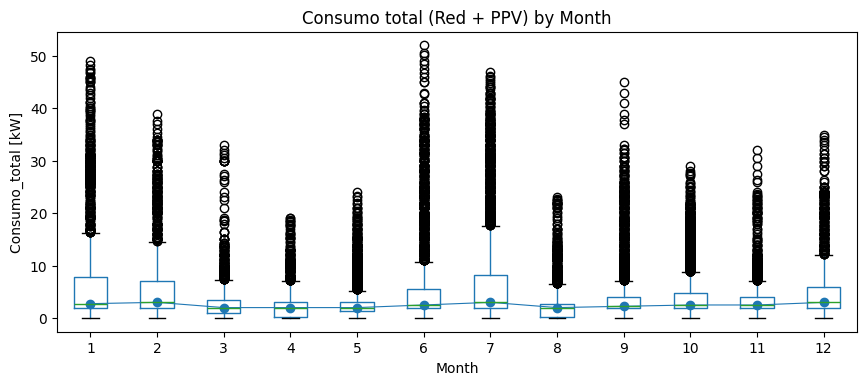

In [58]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_kW', by='Month', ax=ax)
df5.groupby('Month')['Consumo_kW'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Consumo_total [kW]')
ax.set_title("Consumo total (Red + PPV) by Month")
fig.suptitle('')

## Consumo total por día

Text(0.5, 0.98, '')

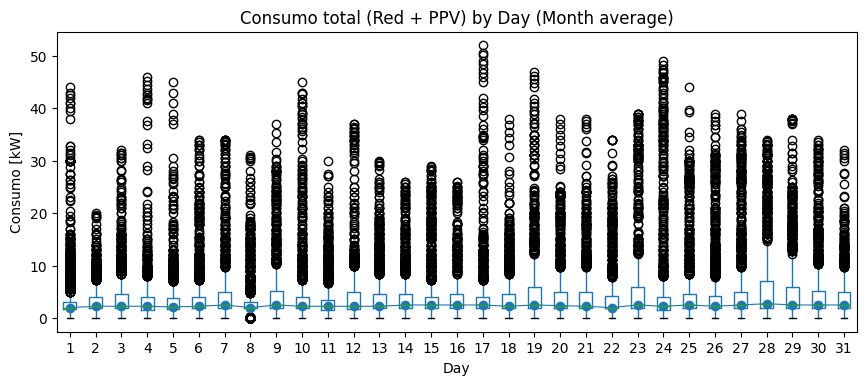

In [59]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_kW', by='Day', ax=ax)
df5.groupby('Day')['Consumo_kW'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Consumo [kW]')
ax.set_title("Consumo total (Red + PPV) by Day (Month average)")
fig.suptitle('')

Text(0.5, 0.98, '')

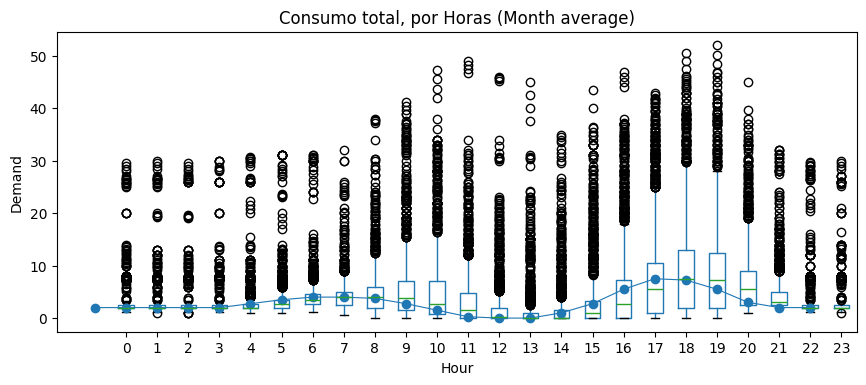

In [60]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_kW', by='Hour', ax=ax)
df5.groupby('Hour')['Consumo_kW'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title("Consumo total, por Horas (Month average)")
fig.suptitle('')

## Demand per Day and Season

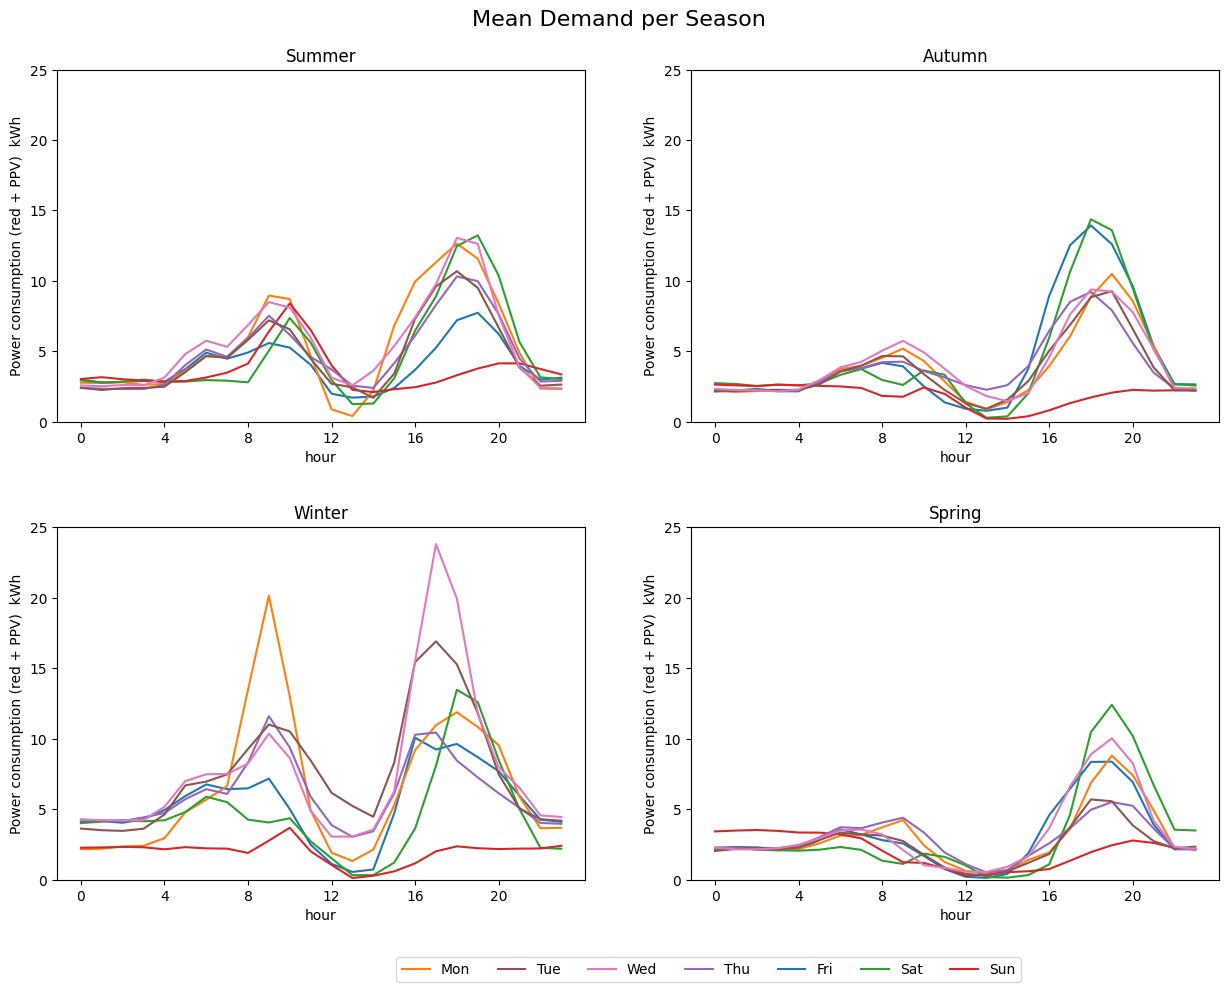

In [61]:
days_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df5["Day"] = df5["DayOfWeek"].map(days_mapping)
df5["Season"] = df5["Month"].apply(
    lambda x: (
        1 if x in [3, 4, 5] #Spring
        else 2 if x in [6, 7, 8] #Summer
        else 3 if x in [9, 10, 11] #Autumn
        else 0 #Winter
    )
)
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.3, top=0.92)
fig.suptitle("Mean Demand per Season", fontsize=16)

fig.set_figheight(10)
fig.set_figwidth(15)

ymin, ymax = 0, 25

#Season Summer
df5.loc[df5["Season"] == 2] \
    .groupby([df5.loc[df5["Season"] == 2]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[0, 0], ylim=(ymin, ymax), title="Summer", legend=False
    )
df5.loc[df5["Season"] == 3] \
    .groupby([df5.loc[df5["Season"] == 3]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[0, 1], ylim=(ymin, ymax), title="Autumn", legend=False
    )
df5.loc[df5["Season"] == 0] \
    .groupby([df5.loc[df5["Season"] == 0]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[1, 0], ylim=(ymin, ymax), title="Winter", legend=False
    )
df5.loc[df5["Season"] == 1] \
    .groupby([df5.loc[df5["Season"] == 1]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[1, 1], ylim=(ymin, ymax), title="Spring", legend=False
    )

for ax in axes.flat:
    ax.set(xlabel='hour', ylabel='Power consumption (red + PPV)  kWh')

for n in range(0, 2):
    axes[n, 0].set_xticks([0, 4, 8, 12, 16, 20])
    axes[n, 1].set_xticks([0, 4, 8, 12, 16, 20])
df5 = df5.drop("Day", axis=1)
# LEGEND
handles, labels = plt.gca().get_legend_handles_labels() # reorder Legend Labels
order = [1,5,6,4,0,2,3]      # specify order in Legend
axes[1,1].legend([handles[i] for i in order], [labels[i] for i in order], loc=1, ncol=7, 
                 bbox_to_anchor=(0.638,-0.2), frameon=True) # print and order LEGEND

## Temperature Distribution by Hour

Text(0.5, 0.98, '')

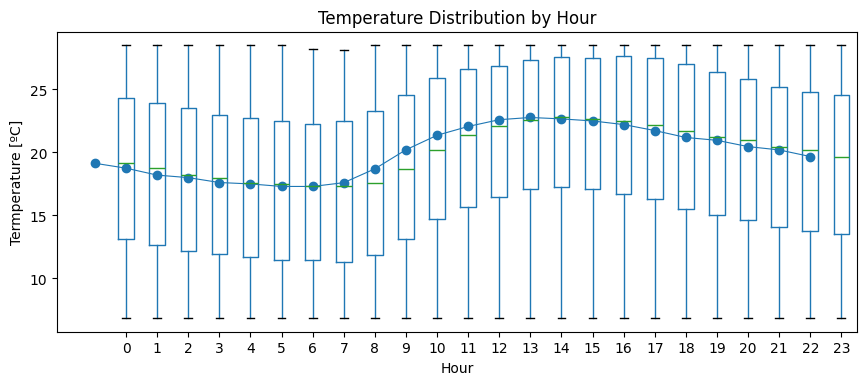

In [62]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='temp_C', by='Hour', ax=ax)
df5.groupby('Hour')['temp_C'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Termperature [ºC]')
ax.set_title("Temperature Distribution by Hour")
fig.suptitle('')

## Relacion entre Demanda Energética y Temperatura. 

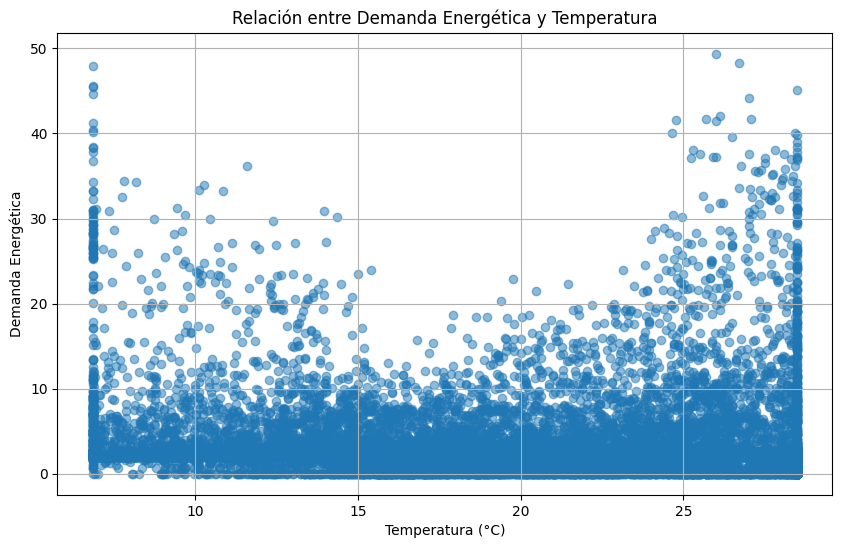

In [63]:
def plot_temp_vs_demand(df):
    df = df.copy()
    df.set_index("Date", inplace=True)
    df_1h = df.resample('1h').mean()
    plt.figure(figsize=(10, 6))
    plt.scatter(df_1h['temp_C'], df_1h['Consumo_kW'], alpha=0.5)
    plt.title('Relación entre Demanda Energética y Temperatura')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Demanda Energética')
    plt.grid(True)
    plt.show()
plot_temp_vs_demand(df5)

Si hubiese buena correlacion entre demanda y temperatura, los puntos deberían formar una especie de "U", ya que cuanto mayor o menor sea la temperatura, mayor será el consumo energético para mejorar el confort. 

Por otro lado, los bordes rectos se deben a la windsorización de la temperatura en el preprocessing. 

## Irradiacion Solar (Mensual)

Text(0.5, 0.98, '')

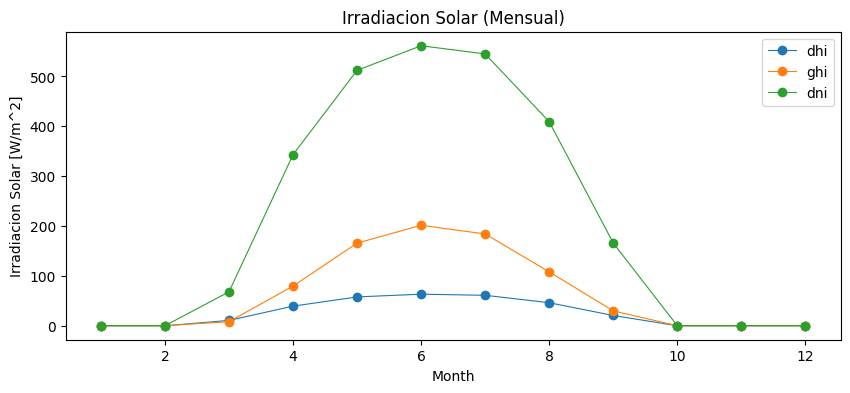

In [64]:
fig, ax = plt.subplots(figsize=(10, 4))

# df5.boxplot(column='dhi_W/m2', by='Month', ax=ax)
df5.groupby('Month')['dhi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='ghi_W/m2', by='Month', ax=ax)
df5.groupby('Month')['ghi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='dni_W/m2', by='Month', ax=ax)
df5.groupby('Month')['dni_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

ax.legend(['dhi', 'ghi', 'dni'])

# dhi                      Irradiancia solar difusa en el plano horizontal    W/m2 [Clear Sky] 
# ghi                      Irradiancia solar global en el plano horizontal    W/m2 [Clear Sky] 
# dni                      Irradiancia solar directa normal                   W/m2 [Clear Sky] 

ax.set_ylabel('Irradiacion Solar [W/m^2]')
ax.set_title("Irradiacion Solar (Mensual)")
fig.suptitle('')

## Irradiacion Solar (Horaria)

Text(0.5, 0.98, '')

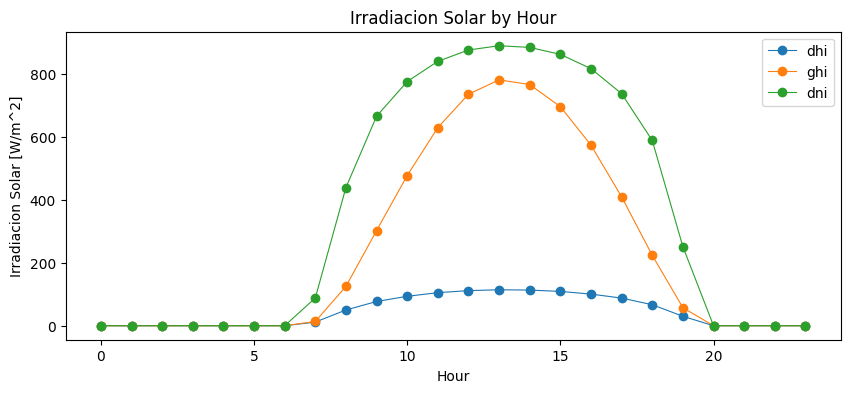

In [65]:
fig, ax = plt.subplots(figsize=(10, 4))

# df5.boxplot(column='dhi_W/m2', by='Hour', ax=ax)
df5.groupby('Hour')['dhi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='ghi_W/m2', by='Hour', ax=ax)
df5.groupby('Hour')['ghi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='dni_W/m2', by='Hour', ax=ax)
df5.groupby('Hour')['dni_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

ax.legend(['dhi', 'ghi', 'dni'])

# dhi                      Irradiancia solar difusa en el plano horizontal    W/m2 [Clear Sky] 
# ghi                      Irradiancia solar global en el plano horizontal    W/m2 [Clear Sky] 
# dni                      Irradiancia solar directa normal                   W/m2 [Clear Sky] 

ax.set_ylabel('Irradiacion Solar [W/m^2]')
ax.set_title("Irradiacion Solar by Hour")
fig.suptitle('')

## AutoCorrelation Plots

In [66]:
df5.head()

Date  Consumo_kW  Consumo_smooth_mean_kW  pres_mb  slp_mb  \
0 2022-07-02 00:00:00        3.00                     NaN   1019.0  1020.0   
1 2022-07-02 00:15:00        2.75                     NaN   1019.0  1020.0   
2 2022-07-02 00:30:00        2.50                     NaN   1019.0  1020.0   
3 2022-07-02 00:45:00        2.25                     NaN   1019.0  1020.0   
4 2022-07-02 01:00:00        2.00                     NaN   1019.0  1020.0   

   wind_dir_m/s  wind_gust_spd_m/s  wind_spd_m/s  temp_C  app_temp_C  ...  \
0         150.0                2.8           1.5  23.100      23.000  ...   
1         192.5                2.6           1.5  22.825      22.725  ...   
2         235.0                2.6           1.5  22.550      22.450  ...   
3         277.5                2.6           1.5  22.275      22.175  ...   
4         320.0                2.6           1.5  22.000      21.900  ...   

   Hour_sin  Hour_cos  DayOfWeek_sin  DayOfWeek_cos  Month_sin  Month_cos  \
0   -0.2588    0.9659        -0.4339         -0.901        0.0       -1.0   
1   -0.2588    0.9659        -0.4339         -0.901        0.0       -1.0   
2   -0.2588    0.9659        -0.4339         -0.901        0.0       -1.0   
3   -0.2588    0.9659        -0.4339         -0.901        0.0       -1.0   
4    0.0000    1.0000        -0.4339         -0.901        0.0       -1.0   

   DayOfYear_sin  DayOfYear_cos  isHoliday  Season  
0         0.0086           -1.0      False       2  
1         0.0086           -1.0      False       2  
2         0.0086           -1.0      False       2  
3         0.0086           -1.0      False       2  
4         0.0086           -1.0      False       2  

[5 rows x 37 columns]

In [67]:
from statsmodels.graphics.tsaplots import plot_acf
#Gráfico de autocorrelación 1
df.set_index("Date", inplace=True)
demand_df_1h = df.resample('1h').mean()
fig, ax = plt.subplots(figsize=(13, 3))
plt.xlabel("Nº of lags")
plot_acf(demand_df_1h["Consumo_kW"], ax=ax, lags=24*7)
plt.show()

KeyError: "None of ['Date'] are in the columns"

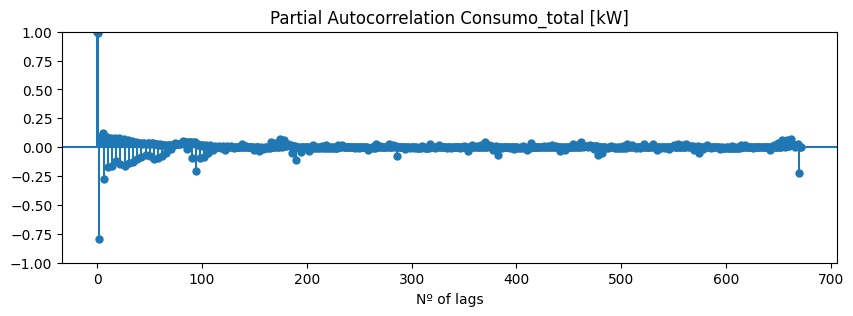

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
#Gráfico de autocorrelación parcial
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº of lags")
plot_pacf(demand_df_1h["Consumo_kW"], ax=ax, lags=24*7)
plt.title("Partial Autocorrelation Consumo_total [kW]")
plt.show()

## Correlation Matrix

In [ ]:
df5.columns

Index(['Date', 'Consumo_kW', 'Consumo_smooth_mean_kW', 'pres_mb', 'slp_mb',
       'wind_dir_m/s', 'wind_gust_spd_m/s', 'wind_spd_m/s', 'temp_C',
       'app_temp_C', 'rh_%', 'dewpt_C', 'dhi_W/m2', 'dni_W/m2', 'ghi_W/m2',
       'solar_rad_W/m2', 'uv_0-11', 'elev_angle_º', 'azimuth_º',
       'Temp interna Modulo_C', 'PV_Wh', 'Year', 'Month', 'Hour', 'DayOfWeek',
       'DayOfYear', 'isWeekend', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'DayOfYear_sin',
       'DayOfYear_cos', 'isHoliday', 'Season'],
      dtype='object')

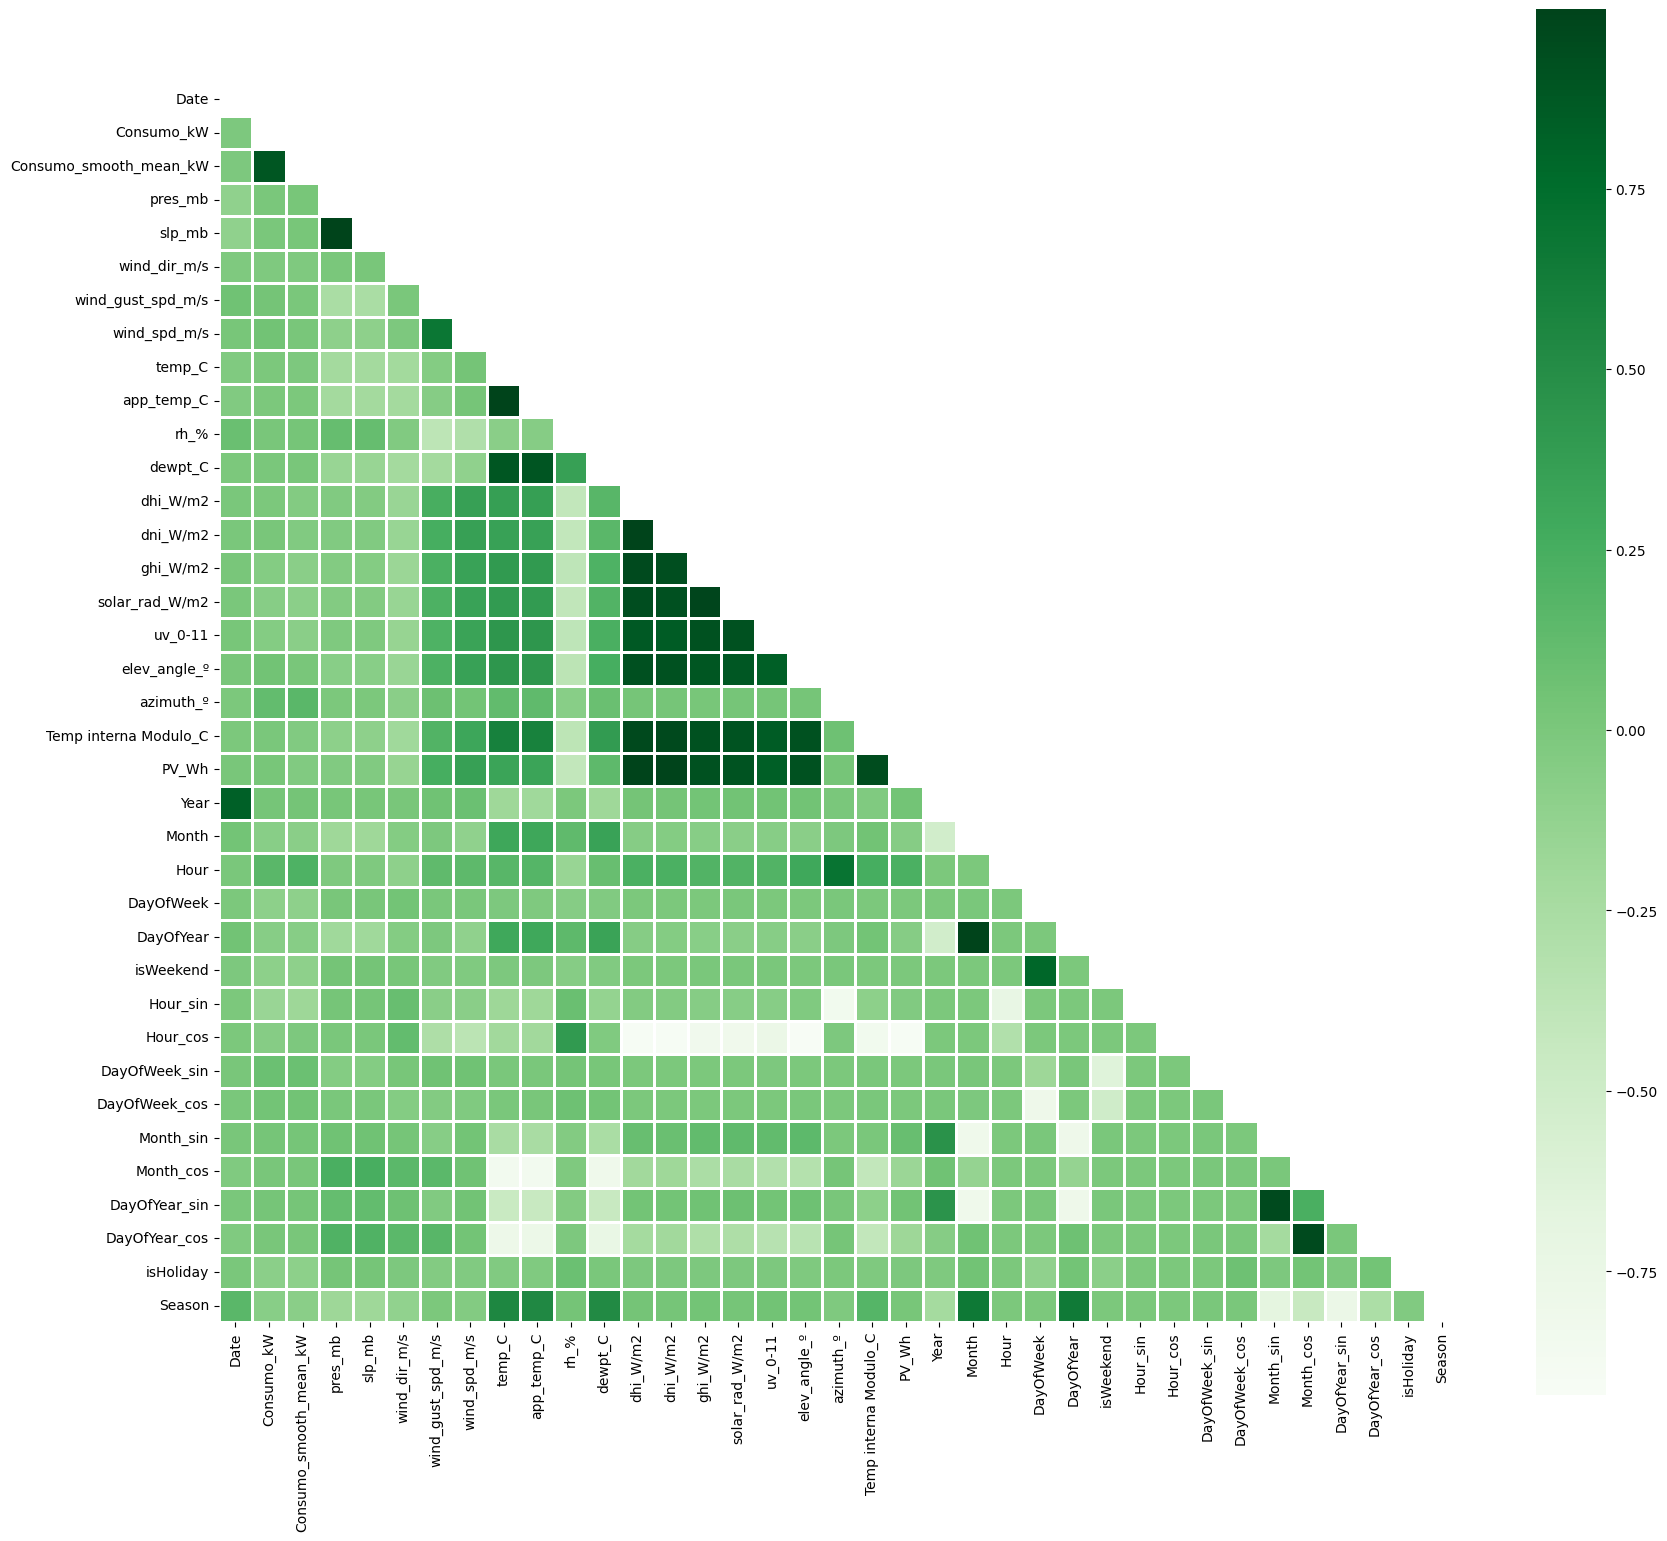

In [ ]:
# Calcula la matriz de correlación completa
correlation_matrix = df5.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Imprime la matriz de correlación del cuadrante inferior
#plotting the heatmap for correlation
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, mask=mask, square=True, cmap='Greens', linewidths=2, linecolor='white');

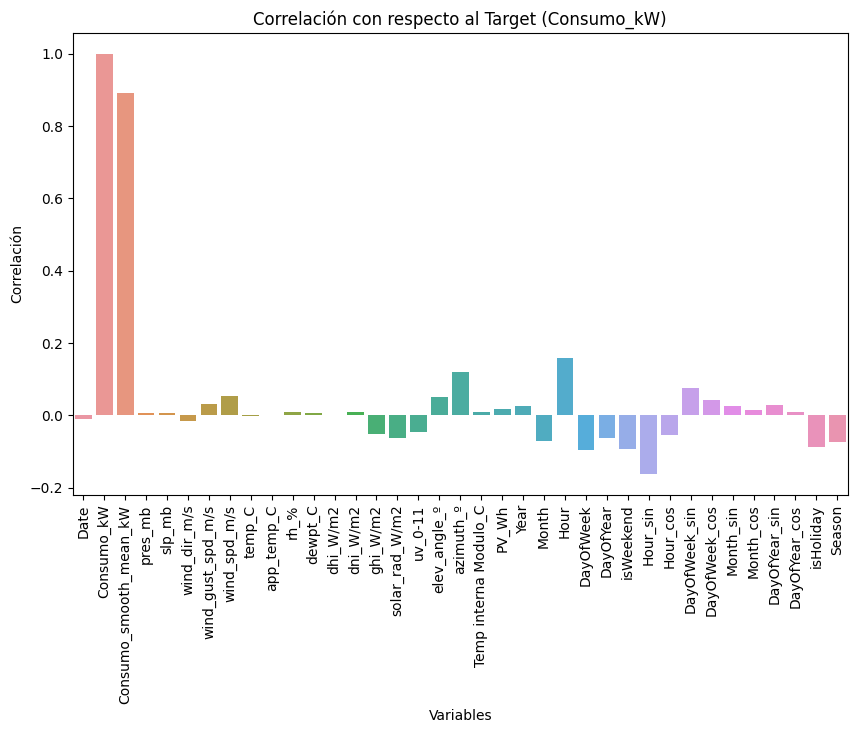

In [ ]:
# Crear un gráfico de barras de la correlación respecto a la variable específica
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_matrix.index, y=correlation_matrix['Consumo_kW'])
plt.title('Correlación con respecto al Target (Consumo_kW)')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=90)
plt.show()

## Time series decpomposition

In [ ]:
def decompose_time_series(df, column, freq):
    result = seasonal_decompose(df[column], model='additive', period=freq)
    df[f"{column}_trend"] = result.trend
    df[f"{column}_seasonal"] = result.seasonal
    df[f"{column}_residual"] = result.resid
    return df


decomposed_df = decompose_time_series(df5, "Consumo_kW", 96)

decomposed_df.set_index('Date', inplace=True)

# Plot the decomposed time series
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
decomposed_df["Consumo_kW"].plot(ax=axes[0], title="Original")
decomposed_df["Consumo_kW_trend"].plot(ax=axes[1], title="Trend")
decomposed_df["Consumo_kW_seasonal"].plot(ax=axes[2], title="Seasonal")
decomposed_df["Consumo_kW_residual"].plot(ax=axes[3], title="Residual")
plt.tight_layout()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x00000251B85432E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000251B8560EA0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

# SAVE csv

In [ ]:
# Guardar el DataFrame como CSV
nombre_archivo = "LaMonserratina_CLEAN.csv"
ruta_completa = os.path.join(ruta_data, nombre_archivo)
df5.to_csv(ruta_completa, index=False)